In [1]:
#uncomment all lines below in this cell to replicate my installation on colab

!pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes psaw pyarrow
!apt-get install libproj-dev proj-data proj-bin  
!apt-get install libgeos-dev  
!pip install cython  
!pip install cartopy 
!brew install proj geos
!pip3 uninstall shapely
!pip3 install --upgrade cython numpy pyshp six
!pip3 install shapely --no-binary shapely
!pip3 install git+https://github.com/SciTools/cartopy.git --no-binary cartopy

     |████████████████████████████████| 14.7MB 292kB/s 
     |████████████████████████████████| 931kB 43.1MB/s 
     |████████████████████████████████| 1.6MB 43.7MB/s 
     |████████████████████████████████| 235kB 43.9MB/s 
     |████████████████████████████████| 10.9MB 43.9MB/s 
     |████████████████████████████████| 552kB 41.1MB/s 
  Created wheel for qeds: filename=qeds-0.6.2-cp36-none-any.whl size=27820 sha256=a33aa8d38f4b78a0330f824df978dddeb44908dcd0d920ae91a1d9f0e6691802
  Stored in directory: /root/.cache/pip/wheels/b7/0b/74/c09109813c2b6116a2d4f2833c354b24163672f846a50fc7b4
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=7f8fc88427e1a22d8c9079eb4aed7a4ee2e90ee29a354a0ccf44e74b74e73c3b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=35802be3dcb2e705054031a73abefdfbea353d0ba1f6d337f94dccdb34

     |████████████████████████████████| 358kB 2.7MB/s 
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for shapely ... done
  Cloning https://github.com/SciTools/cartopy.git to /tmp/pip-req-build-4_2xky6x
  Running command git clone -q https://github.com/SciTools/cartopy.git /tmp/pip-req-build-4_2xky6x
Skipping wheel build for Cartopy, due to binaries being disabled for it.
  Found existing installation: Cartopy 0.18.0
    Uninstalling Cartopy-0.18.0:
      Successfully uninstalled Cartopy-0.18.0
    Running setup.py install for Cartopy ... done


In [0]:
import pandas as pd 
import os
import IPython

import json
with open("to_from_data.json", "r") as read_file:
    rankings = json.load(read_file)
data = pd.DataFrame(rankings)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import qeds
qeds.themes.mpl_style();

import cartopy.crs as ccrs #cartopy documentation: https://scitools.org.uk/cartopy/docs/latest/
import cartopy.feature as cfeature

#import geopandas as gpd
#from shapely.geometry import Point

In [0]:
inst_data = pd.read_json("to_from_data.json") #set directory as necessary

In [0]:
inst_data["startdate"] = pd.to_datetime(inst_data["startdate"]) #convert object to datetime

In [6]:
inst_data.name.unique().shape #note 33 unique categories, names

(33,)

In [7]:
inst_data.description.unique() #note 10 unique recruiter_types, descriptions

array(['Academic organization (economics department)',
       'Private (non-profit) business or organization',
       'Academic organization (agricultural/resource economics department)',
       'Academic organization (business school)',
       'Academic organization (other than econ, business, or ag econ)',
       'Government agency or commission', 'Other type of organization',
       'Private (for profit) business or organization',
       'Human Resources department of educational or non-profit institution',
       'Advertising agency or executive recruiter'], dtype=object)

In [8]:
import nltk
nltk.download("punkt")

def desc_reviser(string):
    string = string.lower()
    tokens = [i for i in nltk.tokenize.word_tokenize(string)]
    return(tokens)

#desc_reviser(inst_data.description[6])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
desc_tokens = [desc_reviser(i) for i in inst_data.description]
inst_data["desc_tokens"] = desc_tokens

In [10]:
inst_data["revised_description"] = 0

for i in inst_data.index:
    if "academic" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = inst_data.description[i]
        
    elif "government" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = inst_data.description[i]
        
    elif "private" or "other" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = "Private business or organization; Other type of organization"
        
    else: inst_data["revised_description"][i] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/

In [0]:
inst_data['revised_recruiter_hash'] = inst_data.revised_description.map(hash) #create column of revised recruiter types

In [0]:
inst_data["from_coordinates"] = list(zip(inst_data.longitude, inst_data.latitude))
inst_data["to_coordinates"] = list(zip(inst_data.to_longitude, inst_data.to_latitude))

In [0]:
data_subsets = {}
for i in inst_data.category_id.unique():
    inst_data_subset_iteration = inst_data[inst_data.category_id == i]
    data_subsets[i] = inst_data_subset_iteration

In [14]:
!pip install seaborn-qqplot

  Created wheel for seaborn-qqplot: filename=seaborn_qqplot-0.3.2-cp36-none-any.whl size=12632 sha256=5f38800095d101729f955eb9f6728d703974c49ba712eb72dd25d3a402a5482a
  Stored in directory: /root/.cache/pip/wheels/4e/37/aa/3aa9b433dfe80aebcec84b2970849fc3cb4d6e4f67ff89458b
Successfully built seaborn-qqplot


In [15]:
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as st
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels
import seaborn_qqplot as sqp
import statsmodels.discrete.discrete_model as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


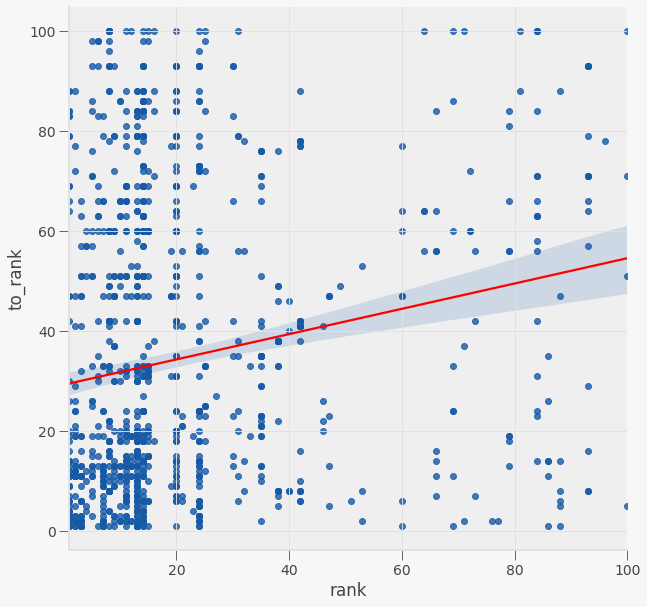

In [16]:
data_clean_rank = inst_data.dropna(subset = ["rank", "to_rank"])
fig, ax = plt.subplots(figsize = (10, 10))
rank_scat = sns.regplot(x = "rank", y = "to_rank", data = data_clean_rank, ax = ax)
rank_scat.get_lines()[0].set_color("red")

In [17]:
skew = pd.DataFrame(data_clean_rank.skew(), columns = ["skewness"])
kurt = pd.DataFrame(data_clean_rank.kurtosis(), columns = ["kurtosis"])
skewkurt = pd.concat([skew, kurt], axis = 1)
fulldesc = pd.concat([data_clean_rank.describe(), skewkurt.T])
fulldesc

,aid,to_institution_id,to_oid,to_latitude,to_longitude,to_rank,recruiter_type,from_oid,from_institution_id,latitude,longitude,category_id,rank,revised_recruiter_hash
count,1210.000000,1210.000000,1210.000000,1124.000000,1124.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1.210000e+03
mean,28022.109091,281.255372,595.200826,39.347232,-45.390382,34.437190,1.450413,333.198347,265.276033,41.339156,-59.320042,9.784298,20.584298,3.728523e+18
std,14861.038705,279.052782,700.774333,17.295089,67.780175,28.828774,1.088144,323.898202,285.827069,11.168140,49.505632,6.318190,20.640407,3.981177e+18
min,7.000000,2.000000,20.000000,-37.912641,-123.253794,1.000000,1.000000,20.000000,2.000000,-37.801380,-123.250418,1.000000,1.000000,-8.237169e+18
25%,13573.000000,73.000000,139.000000,38.983057,-83.737582,11.000000,1.000000,85.250000,17.000000,39.953339,-83.737582,6.000000,8.000000,5.515937e+18
50%,33403.000000,184.000000,361.000000,41.789922,-74.655533,24.000000,1.000000,217.000000,186.000000,41.313892,-74.655533,10.000000,14.000000,5.515937e+18
75%,41955.250000,361.000000,886.000000,47.657111,-1.194493,57.750000,1.000000,406.000000,350.000000,42.376417,-71.083557,13.000000,24.000000,5.515937e+18
max,47690.000000,1104.000000,5051.000000,59.362174,153.013491,100.000000,8.000000,1347.000000,1089.000000,59.362174,153.013491,34.000000,100.000000,5.515937e+18
skewness,-0.427576,1.229953,2.216633,-3.441758,1.396352,0.711909,3.229377,1.234817,1.066048,-4.929478,1.709218,0.706839,2.060622,-2.276005e+00
kurtosis,-1.349272,0.681526,5.764407,12.416536,1.390454,-0.766935,12.683500,0.511837,-0.019915,32.668148,3.831658,0.720395,3.873360,3.941332e+00


Text(0.5, 1.0, 'Correlation Matrix')

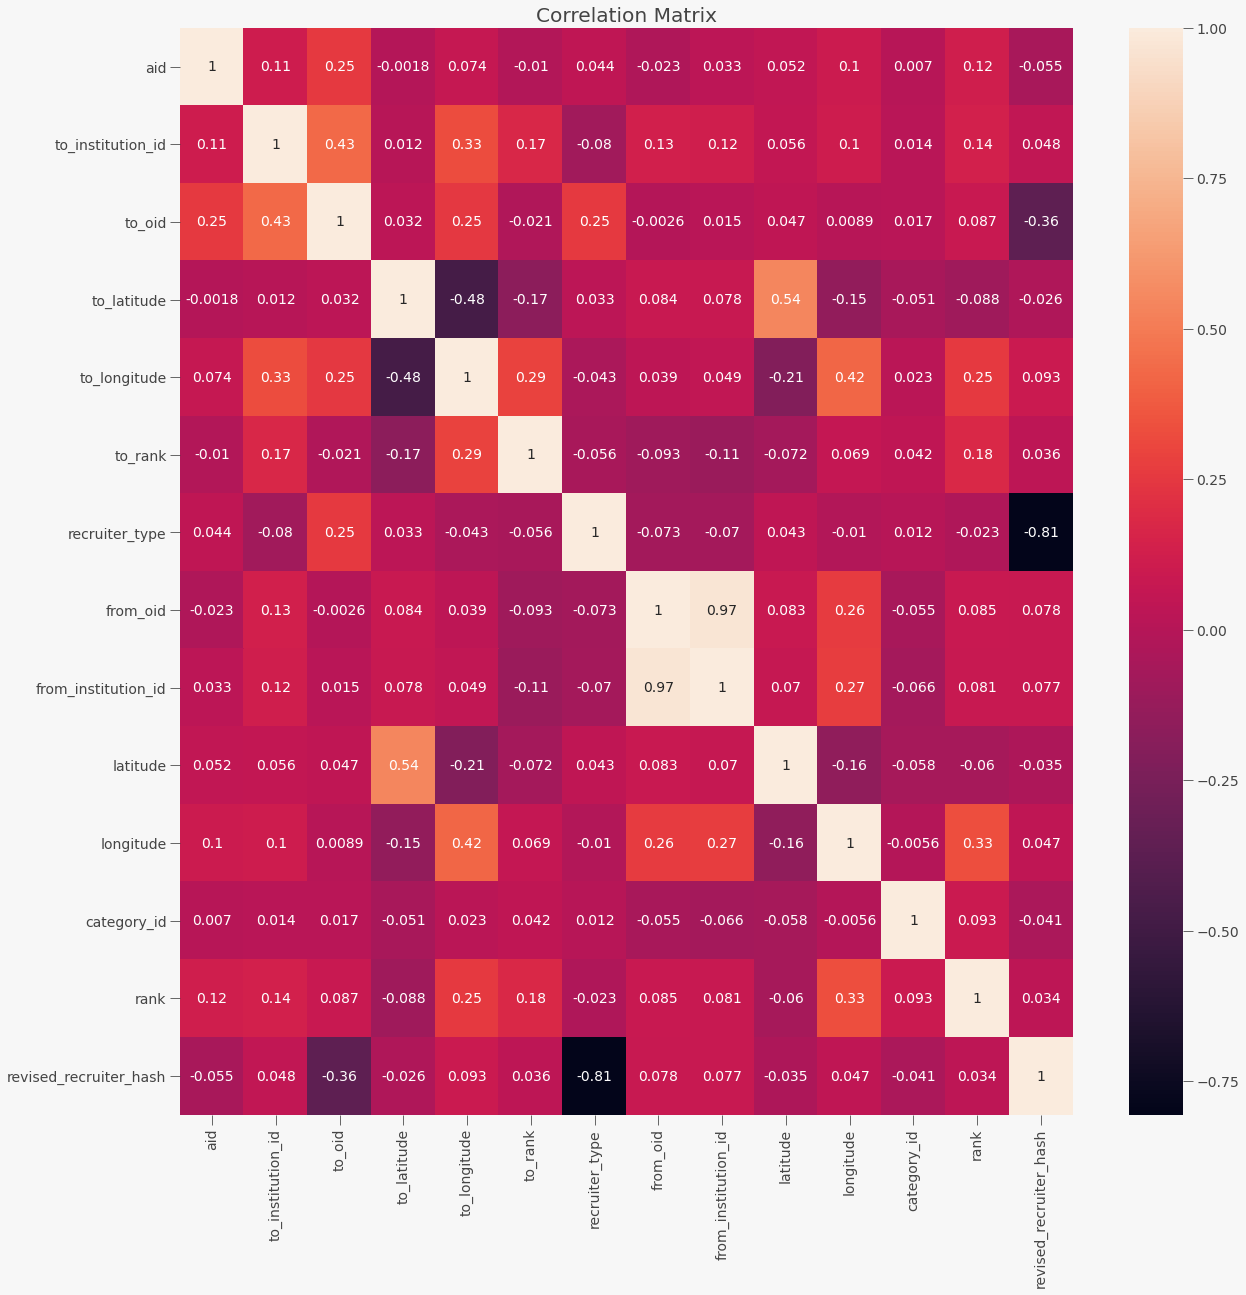

In [18]:
fig, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(data_clean_rank.corr(), annot = True)
ax.set_title("Correlation Matrix")

In [19]:
torank_rank_regression = smf.ols(formula = "to_rank ~ rank", data = data_clean_rank)
torank_rank_regression = torank_rank_regression.fit()
torank_rank_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                to_rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     41.14
Date:                Sun, 17 May 2020   Prob (F-statistic):           2.03e-10
Time:                        00:18:36   Log-Likelihood:                -5763.4
No. Observations:                1210   AIC:                         1.153e+04
Df Residuals:                    1208   BIC:                         1.154e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2196      1.152     25.370      0.000      26.960      31.479
rank           0.2535      0.040      6.414      0.000       0.176       0.331
==============================================================================
Omnibus:                      132.544   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.685
Skew:                           0.722   Prob(JB):                     5.10e-28
Kurtosis:                       2.362   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
torank_rank_regression_hc1 = smf.ols(formula = "to_rank ~ rank", data = data_clean_rank)
torank_rank_regression_hc1 = torank_rank_regression_hc1.fit(cov_type = "HC1")
torank_rank_regression_hc1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                to_rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     35.39
Date:                Sun, 17 May 2020   Prob (F-statistic):           3.54e-09
Time:                        00:21:57   Log-Likelihood:                -5763.4
No. Observations:                1210   AIC:                         1.153e+04
Df Residuals:                    1208   BIC:                         1.154e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2196      1.179     24.788      0.000      26.909      31.530
rank           0.2535      0.043      5.949      0.000       0.170       0.337
==============================================================================
Omnibus:                      132.544   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.685
Skew:                           0.722   Prob(JB):                     5.10e-28
Kurtosis:                       2.362   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

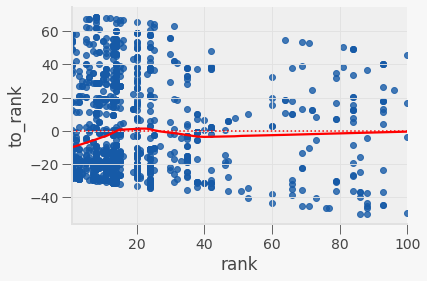

In [23]:
torank_rank_resid = sns.residplot(data_clean_rank["rank"], data_clean_rank["to_rank"], lowess=True)
torank_rank_resid.get_lines()[0].set_color("r")
torank_rank_resid.get_lines()[1].set_color("r")

Text(0.5, 0, 'fitted_values')

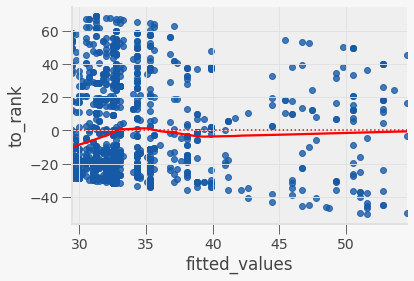

In [28]:
fig, ax = plt.subplots()
fit_resid = sns.residplot(torank_rank_regression_hc1.fittedvalues, data_clean_rank["to_rank"], lowess = True, ax = ax)
fit_resid.get_lines()[0].set_color("r")
fit_resid.get_lines()[1].set_color("r")
ax.set_xlabel("fitted_values")

In [37]:
st.shapiro(torank_rank_regression_hc1.resid) #tests null hypothesis that sample came from normally distributed population; if p value less than alpha, reject null i.e. evidence data tested not normally distributed

(0.9091321229934692, 2.936445048387006e-26)

In [38]:
white_test = het_white(torank_rank_regression_hc1.resid, torank_rank_regression_hc1.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F Statistic", "F-Test p-value"]
whitedict = dict(zip(labels, white_test))
whitedata = pd.DataFrame.from_dict(whitedict, orient = 'index')
whitedata = whitedata.rename(columns = {0 : "White Test Values"})
whitedata

,White Test Values
LM Statistic,5.796547
LM-Test p-value,0.055118
F Statistic,2.905004
F-Test p-value,0.055131


In [44]:
breuschpagan_test = statsmodels.stats.diagnostic.het_breuschpagan(torank_rank_regression_hc1.resid, torank_rank_regression_hc1.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F Statistic", "F-Test p-value"]
breuschpagandict = dict(zip(labels, breuschpagan_test))
breuschpagandata = pd.DataFrame.from_dict(breuschpagandict, orient = 'index')
breuschpagandata = breuschpagandata.rename(columns = {0 : "Breusch-Pagan Test Values"})
breuschpagandata

,Breusch-Pagan Test Values
LM Statistic,1.006099
LM-Test p-value,0.315839
F Statistic,1.005272
F-Test p-value,0.316239


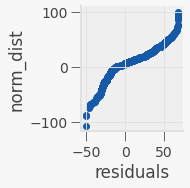

In [45]:
resid_data = pd.DataFrame(torank_rank_regression_hc1.resid)
all_data = pd.concat([data_clean_rank, resid_data], axis = 1)
all_data = all_data.rename(columns = {0: "residuals"})
sqp.qqplot(all_data, x = "residuals", y = st.norm)

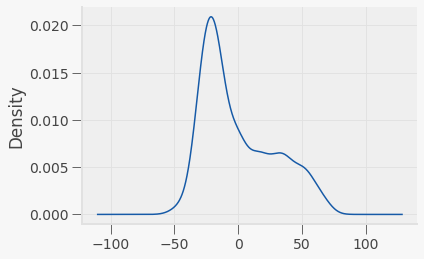

In [47]:
torank_rank_regression_hc1.resid.plot.kde()

In [0]:
#create dummies for recruiter types
data_dummies_rectype = pd.get_dummies(inst_data["revised_description"])

In [0]:
data_with_dummies = pd.concat([inst_data, data_dummies_rectype], axis = 1)

In [0]:
data_with_dummies = data_with_dummies.rename(columns = {"Government agency or commission": "govt", "Academic organization (economics department)": "econ", "Academic organization (agricultural/resource economics department)": "ag_econ", "Academic organization (business school)": "bsns", "Academic organization (other than econ, business, or ag econ)": "ac_othr", "Private business or organization; Other type of organization": "priv"})

In [54]:
data_with_dummies["academia"] = 0

for i in data_with_dummies.index:
    if data_with_dummies.econ[i] == 1 or data_with_dummies.bsns[i] == 1 or data_with_dummies.ac_othr[i] == 1 or data_with_dummies.ag_econ[i] == 1:
      data_with_dummies.academia[i] = 1
    else:
      data_with_dummies.academia[i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [56]:
from patsy import dmatrices

y_govt, X_rank = dmatrices("govt ~ rank", data_with_dummies, return_type = "dataframe")

govt_regression = sm.Logit(y_govt, X_rank)
govt_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.247266
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   govt   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 May 2020   Pseudo R-squ.:                0.001519
Time:                        00:56:59   Log-Likelihood:                -847.38
converged:                       True   LL-Null:                       -848.67
Covariance Type:            nonrobust   LLR p-value:                    0.1084
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7419      0.102    -26.964      0.000      -2.941      -2.543
rank           0.0049      0.003      1.645      0.100      -0.001       0.011
==============================================================================
"""

In [57]:
from patsy import dmatrices

y_econ, X_rank = dmatrices("econ ~ rank", data_with_dummies, return_type = "dataframe")

econ_regression = sm.Logit(y_econ, X_rank)
econ_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.675846
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   econ   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 May 2020   Pseudo R-squ.:               0.0002129
Time:                        00:57:10   Log-Likelihood:                -2316.1
converged:                       True   LL-Null:                       -2316.6
Covariance Type:            nonrobust   LLR p-value:                    0.3206
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3355      0.052      6.477      0.000       0.234       0.437
rank           0.0016      0.002      0.991      0.322      -0.002       0.005
==============================================================================
"""

In [58]:
from patsy import dmatrices

y_econ, X_rank = dmatrices("academia ~ rank", data_with_dummies, return_type = "dataframe")

econ_regression = sm.Logit(y_econ, X_rank)
econ_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.529936
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               academia   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 May 2020   Pseudo R-squ.:               0.0005607
Time:                        00:57:30   Log-Likelihood:                -1816.1
converged:                       True   LL-Null:                       -1817.1
Covariance Type:            nonrobust   LLR p-value:                    0.1534
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1852      0.061     19.362      0.000       1.065       1.305
rank           0.0028      0.002      1.412      0.158      -0.001       0.007
==============================================================================
"""

In [59]:
from patsy import dmatrices

y_econ, X_rank = dmatrices("priv ~ rank", data_with_dummies, return_type = "dataframe")

econ_regression = sm.Logit(y_econ, X_rank)
econ_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.430005
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   priv   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 May 2020   Pseudo R-squ.:                0.002755
Time:                        00:57:44   Log-Likelihood:                -1473.6
converged:                       True   LL-Null:                       -1477.7
Covariance Type:            nonrobust   LLR p-value:                  0.004326
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5449      0.071    -21.869      0.000      -1.683      -1.406
rank          -0.0067      0.002     -2.759      0.006      -0.012      -0.002
==============================================================================
"""

In [0]:
#create dummies for applicants primary fields
data_dummies_appfie = pd.get_dummies(inst_data["name"])

In [0]:
data_with_dummies = pd.concat([inst_data, data_dummies_rectype, data_dummies_appfie], axis = 1)